# Оценка результатов А/В эксперимента

Я, как продуктовый аналитик отдела маркетинга, провела A/B-тест в ходе которого проверяла, насколько эффективно показывать рекламное предложение на экране оплаты. 
За группу А вы обозначила тех клиентов, которые видели экран оплаты без рекламного предложения, за группу Б - тех кто видел рекламное предложение.

Доступные данные:

Таблица orders:
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ;
- id_trans — идентификатор заказа;
- id_user — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ.

Таблица users:
- group — группа A/B-теста;
- users — количество пользователей в указанную дату в указанной группе A/B-теста
- date — дата.

##  Предварительное исследование

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind, norm
from statsmodels. stats.weightstats import ztest as ztest
from scipy import stats

In [2]:
# Загрузка данных
orders = pd.read_excel("data.xlsx", sheet_name=0)
orders.columns = ['id_trans','id_user','date','revenue','group']

users = pd.read_excel("data.xlsx", sheet_name=1)
users.columns = ['date','group','unique_users']

In [3]:
# Очистка данных

# Удалим выбросы (по 2 самых дорогих покупки из каждой группы), так как значение в 1млн+ возможно ошибочно, либо просто нетипично данному ряду

orders = orders[orders.groupby('group')['revenue'].transform(lambda x: x <= x.quantile(0.998))]

# Удалим пользователей, которые были в обеих группах
a_users = orders[orders['group']=='A']['id_user'].to_list()
b_users = orders[orders['group']=='B']['id_user'].to_list()

users_for_del = set(a_users) & set(b_users)
orders = orders[~orders['id_user'].isin(users_for_del)]

In [4]:
orders.head()

,id_trans,id_user,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [5]:
users.head()

,date,group,unique_users
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Что должна включать в себя постановка задачи на проведение эксперимента?
Для корректного проведения эксперимента необходимо сформулировать цель, описать внедряемое изменение и предложить метрики, которые будем считать критериями успеха при подведении результатов. После этого, необходимо подобрать дизайн эксперимента и подобрать статистические критерии для метрик для оценки эффектов.

#### Цель: Увеличить выручку с помощью дополнительного информирования "горячих" клиентов о продуктах на этапе оплаты.

#### Описание изменения для тестирования (желательно более точно): 
На экран оплаты разместить баннер с рекламой товаров магазина VS экран оплаты без рекламного баннера. 

Возможное изменение поведения пользователя в связи с изменением: увидев баннер на этапе оплаты, клиент вернется на этап корзины и дополнит корзину другими товарами. Другой вариант: клиент оплатит заказ, а затем сделает еще один заказ с предлагаемым товаром (хотя в задаче не сказано, на какое целевое действие ведет баннер). 
Таким образом, клиентами-участниками теста становятся только те клиенты, которые дошли до этапа оплаты.

#### Основная метрика: 
- выручка с платящего клиента (ARPPU): баннер будут видеть только клиенты, которые дошли до экрана оплаты. Предполагается, что эти клиенты совершат больше покупок или покупки на более высокий средний чек, в связи с чем каждый клиент принесет больше выручки.

#### Дополнительные метрики:
- частота покупок: баннер на этапе оплаты может стимулировать после покупки вернуться в магазин и купить что-то еще отдельным чеком.
- средний чек: предполагаю, что баннер будет побуждать клиента вернуться на предыдущие этапы воронки и купить дополнительные товары, что расширит его текщую корзину.

#### Дизайн эксперимента: 
После расчета длительности эксперимента на исторических данных по основной метрике и подобранному стат. тесту, запускаем эксперимент на случайных пользователей (а не, например, по заранее заданному по определенным фильтрам сегменту), так как в дальнейшем будем раскатывать на всех (хотя в задаче не сказано, что хотим в дальнейшем принять такое решение)
Статистические критерии указаны при проверке гипотез по ходу исследования.

#### План исследования:
0) Проверка корректности собранных данных (удаление выбросов; удаление клиентов, которые были как и контроле, так и в тесте)
1) Расчет минимального размер выборки и длительность эксперимента для того, чтобы набрать достаточное количество данных для валидных выводов (и понять, есть ли у нас по факту такая выборка)
2) Рассчитать выбранные для тестирования метрики (ARPPU, частота покупок, средний чек)
3) Проверить гипотезы о равенстве средних/распределений между группами по выбранным для тестирования метрикам
4) Проверка дополнительных эффектов эксперимента (выручка с дневной сессии, конверсия) 
5) Выводы и рекомендации для отдела маркетинга и дальнейшего исследования


### Как определяются метрики эксперимента? Какими свойствами должны обладать метрики эксперимента?

- Измеримость: у нас должна быть техническая возможность корректно собирать данные для расчета выбранной метрики
- Репрезентативность: метрика не должна противоречить верхнеуровневым бизнес-целям, а быть опережающей метрикой для них
- Чувствительность к изменениям: метрика должна способствовать выявлению эффекта от тестируемого изменения
- Интерпретируемость+"actionable": изменение метрики должно однозначно интерпретироваться, то есть должно быть понятно, что означает увеличение метрики - успех или ухудшение, в каком случае мы интерпретируем изменение метрики как успешное, и какие действия необходимо предпринять в связи с этим изменением, например, раскатить на всех или не продолжать разработку
- (относительная) Стабильность: Метрика должна оставаться относительно стабильной с течением времени (требования к дисперсии), чтобы не показывать колебания не связанные с проводимым экспериментом. Но при этом она должна быть чувствительна к вводимому изменению.
- Возможность сравнения: Метрику должно быть легко сравнить между сегментами и во времени.

In [6]:
# Сгенерируем таблицу, добавив сессии пользователей с транзациями нулевой выручки для расчета метрики выручки с дневной сессии

# Если бы были полные данные, то можно было бы рассчитать ARPU (сумма выручки на каждого уникального пользователя за период теста)
# В данном случае вместо этого будем суммировать общую выручку по каждой дневной сессии

grouped_orders = orders.groupby(['date', 'group'])['id_user'].nunique().reset_index()
merged = users.merge(grouped_orders, on=['date', 'group'], how='left')
merged['additional_users'] = merged['unique_users'] - merged['id_user'].fillna(0)

orders_all = pd.DataFrame(columns=orders.columns)

for index, row in merged.iterrows():
    date = row['date']
    group = row['group']
    additional_users = int(row['additional_users'])
    
    zero_revenue_data = {
        'id_trans': ['0'] * additional_users,
        'id_user': ['0'] * additional_users,
        'date': [date] * additional_users,
        'revenue': [0] * additional_users,
        'group': [group] * additional_users
    }
    
    zero_revenue_df = pd.DataFrame(zero_revenue_data)
    orders_all = pd.concat([orders_all, zero_revenue_df])


orders_all = pd.concat([orders, orders_all])
orders_all = orders_all.astype({"revenue":'int64'})

orders_all = orders_all.reset_index()

for idx, row in orders_all.iterrows():
    if row.id_trans == '0':
        orders_all.at[idx, 'id_trans'] = f'zero_{idx}'
    elif row.id_trans != '0':    
        orders_all['id_trans']
        
for idx, row in orders_all.iterrows():
    if row.id_user == '0':
        orders_all.at[idx, 'id_user'] = f'zero_{idx}'
    elif row.id_trans != '0':    
        orders_all['id_user']        

sessions_all = orders_all.groupby(['group','date','id_user']).sum()['revenue'].reset_index()

sessions_all['conversion'] = sessions_all['revenue'].apply(lambda x: 1 if x > 0 else 0)

### Как рассчитать размер выборки для A/B-теста?
Размер выборки для АБ теста рассчитывается на основе следующих параметров:
- Уровень значимости (допустимая доля ошибок первого рода, вероятность ошибочно найти эффект там, где его нет)
- Мощность теста (допустимая доля ошибок второго рода, вероятность не заметить эффект там, где он есть)
- Базовое значение исследуемой метрики, ее дисперсия и форма распределения
- Ожидаемый эффект (MDE)


Тест проводился в течение 1 месяца. За это время удалось собрать следующее количество пользовательских событий в каждой из групп:

In [7]:
# количество дневных сессий (если клиент заходил и/или покупал несколько раз в день, здесь это учтено как одна сессия)
sessions_all.groupby(['group']).count()['id_user']

group
A    18736
B    18916
Name: id_user, dtype: int64

In [8]:
# количество покупок
orders.groupby(['group']).count()['id_trans']

group
A    467
B    547
Name: id_trans, dtype: int64

In [9]:
# Расчет для основной метрики (ARPPU) и случая применения t-критерия Стьюдента
from statsmodels.stats.power import TTestIndPower

rev_per_paying_users = orders.groupby(['id_user','group']).agg({'id_trans': 'count', 'revenue': 'sum'}).reset_index()


mean_arppu_A = rev_per_paying_users[rev_per_paying_users['group']=='A']['revenue'].mean()
std_arppu_A = rev_per_paying_users[rev_per_paying_users['group']=='A']['revenue'].std()
mean_arppu_B = rev_per_paying_users[rev_per_paying_users['group']=='B']['revenue'].mean()
std__arppu_B = rev_per_paying_users[rev_per_paying_users['group']=='B']['revenue'].std()

mu_control, sigma_control    = mean_arppu_A, std_arppu_A
mu_experiment, sigma_experiment = mean_arppu_B, std__arppu_B

effect = (mu_experiment - mu_control) / ((sigma_control**2 + sigma_experiment**2) / 2) ** 0.5
alpha = 0.05
power = 0.2 # мощность теста: возможность задетектировать различия там, где они есть
ratio = 1.0 #соотношение между группами

analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect, power=power, nobs1=None, ratio=ratio, alpha=alpha)
print('Минимальный размер выборки: %.0f' % result)

# В итоге, нам нужно больше данных, чем у нас есть для метрики (ARPPU) и случая применения t-критерия Стьюдента (и мощности больше 0.2). 
# В данном случае будем применять бустрап для оценки эффектов. 

Минимальный размер выборки: 790


In [10]:
# Расчет для конверсии и случая применения z-критерия
from statsmodels.stats.power import zt_ind_solve_power

mean_conv_A = sessions_all[sessions_all['group']=='A']['conversion'].mean()
std_conv_A = sessions_all[sessions_all['group']=='A']['conversion'].std()
mean_conv_B = sessions_all[sessions_all['group']=='B']['conversion'].mean()
std__conv_B = sessions_all[sessions_all['group']=='B']['conversion'].std()

mu_control, sigma_control    = mean_conv_A, std_conv_A
mu_experiment, sigma_experiment = mean_conv_B, std__conv_B

effect = (mu_experiment - mu_control) / ((sigma_control**2 + sigma_experiment**2) / 2) ** 0.5
alpha = 0.05
power = 0.75 # мощность теста: возможность задетектировать различия там, где они есть
ratio = 1.0 #соотношение между группами

result = zt_ind_solve_power(effect_size=effect, power=power, nobs1=None, ratio=ratio, alpha=alpha)
print('Минимальный размер выборки: %.0f' % result)

# В итоге, у нас есть достаточно данных для проверки метрики конверсии для случая применения z-критерия с мощностью около 0.75
# (хотя по изначальной гипотезе  эта метрика не является основной в эксперименте)

Минимальный размер выборки: 18784


## Оценка А/В теста

In [11]:
# Задаю функцию для генерации бутстрап-подвыборок

iterations = 5000

bootstrap_df1 = pd.DataFrame()
bootstrap_df2 = pd.DataFrame()

for x in tqdm(range(iterations)):  
    iter_df = rev_per_paying_users.sample(frac = 1, replace=True).groupby(['group'], as_index=False).agg(
        arppu = ('revenue', lambda x: x.sum()/len(x)),
        freq = ('id_trans', lambda x: x.sum()/len(x))
    )

    control_iter_df = iter_df[iter_df['group'] == 'A'].reset_index()
    variant_iter_df = iter_df[iter_df['group'] == 'B'].reset_index()
    
    bootstrap_df1 = pd.concat([bootstrap_df1, iter_df])
    
for x in tqdm(range(iterations)):  
    iter_df = sessions_all.sample(frac = 1, replace=True).groupby(['group'], as_index=False).agg(
        rev_per_session = ('revenue', lambda x: x.sum()/len(x)),    
        conversion = ('revenue', lambda x: x[x > 0].count()/len(x))
    )
    control_iter_df = iter_df[iter_df['group'] == 'A'].reset_index()
    variant_iter_df = iter_df[iter_df['group'] == 'B'].reset_index()
    
    bootstrap_df2 = pd.concat([bootstrap_df2, iter_df])    

bootstrap_df2 = bootstrap_df2[['rev_per_session', 'conversion']]
bootstrap_df = pd.concat([bootstrap_df1, bootstrap_df2],axis=1)

bootstrap_df_melt = pd.melt(bootstrap_df, id_vars = 'group', value_vars = ['arppu', 'freq', 'rev_per_session', 'conversion'], var_name = 'kpi')

bootstrap_control = bootstrap_df[bootstrap_df['group'] == 'A'].reset_index()
bootstrap_variant = bootstrap_df[bootstrap_df['group'] == 'B'].reset_index()

# расчет разницы метрик 
bootstrap_diffs = pd.DataFrame()

bootstrap_diffs['arppu_diff'] = bootstrap_variant['arppu'] - bootstrap_control['arppu']
bootstrap_diffs['freq_diff'] = bootstrap_variant['freq'] - bootstrap_control['freq']
bootstrap_diffs['rev_per_session_diff'] = bootstrap_variant['rev_per_session'] - bootstrap_control['rev_per_session']
bootstrap_diffs['conversion_diff'] = bootstrap_variant['conversion'] - bootstrap_control['conversion']

bootstrap_diffs_melt = pd.melt(bootstrap_diffs, value_vars = ['arppu_diff', 'freq_diff', 'rev_per_session_diff', 'conversion_diff'], var_name = 'kpi')
alpha = 0.05

lower_ci = alpha/2
upper_ci = 1 - (alpha/2)

  0%|          | 9/5000 [00:00<00:58, 84.77it/s]

100%|██████████| 5000/5000 [01:19<00:00, 62.87it/s]


In [12]:
# Задаю функцию для оценки с помощью дельта-метода
def check_delta_method(a, b):
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)
        array_x = np.array([np.sum(row) for row in data])
        array_y = np.array([len(row) for row in data])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

Предполагаю, что вводимое изменение должно оказывать эффект на выручку

Сначала рассчитаем и рассмотрим распределения основных метрик, выбранных для эксперимента (ARPPU, средний чек, частота покупок), затем проведем стат. тесты

[Text(0.5, 1.0, 'ARPPU')]

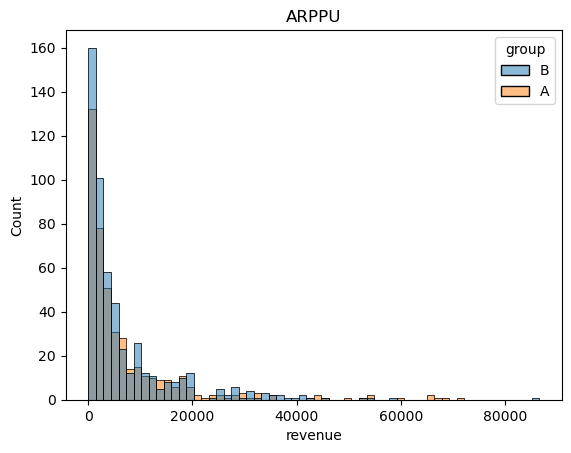

In [13]:
# Рассмотрим основную метрику - выручка с платящего пользователя
# Расчет: для каждого пользователя, совершившего покупку просуммируем выручку всех транзакций за время эксперимента
sns.histplot(data=rev_per_paying_users, x='revenue', hue='group').set(title='ARPPU')
# Выручка с платящего пользователя имеет лог-нормальное распределение

In [14]:
# Выручка с платящего пользователя

summary_table = rev_per_paying_users.groupby('group').agg({'id_user': 'count', 'revenue': ['mean', 'std']}).round(1).reset_index()

summary_table.columns = ['Группа', 'Количество пользователей', 'Средняя выручка', 'Станд. откл.']
summary_table

# Оказалось, что средняя выручка платящих пользователей в тестовой группе - ниже, чем в контрольной
# Статистическую значимость различий проверим с помощью критерия Манна-Уитни и с помощью бутстрапа

,Группа,Количество пользователей,Средняя выручка,Станд. откл.
0,A,444,7369.6,11264.5
1,B,527,6779.1,9720.9


In [15]:
a = list(rev_per_paying_users[rev_per_paying_users['group']=='A']['revenue'])
b = list(rev_per_paying_users[rev_per_paying_users['group']=='B']['revenue'])
mannwhitneyu(a, b).pvalue

# Вывод: С помощью критерия Манна-Уитни на 5% уровне значимости не можем отвергнуть гипотезу 
# о наличии свигов в распределениях между группами для метрики выручки с платящего пользователя

0.7280142519118193

[Text(0.5, 1.0, 'ARPPU')]

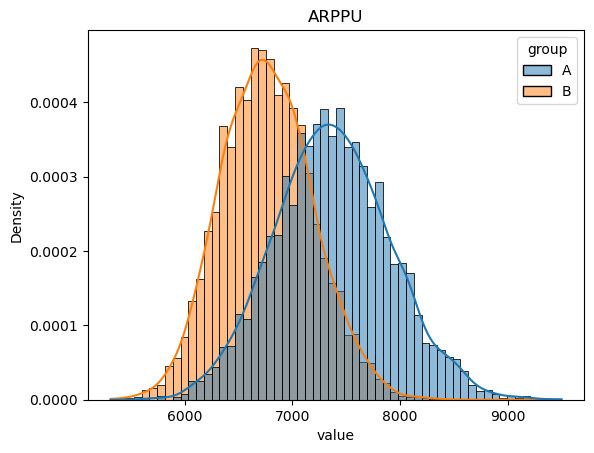

In [16]:
sns.histplot(data = bootstrap_df_melt[bootstrap_df_melt["kpi"] == 'arppu'], x = 'value', kde = True, stat = 'density', common_bins = True, fill = True, hue = 'group').set(title='ARPPU')

# Построим графики распределения средних с помощью бутстрапа
# Распределение средних группы А немного сдвинуто вправо
# Проверим, слуйчайное ли это отличие

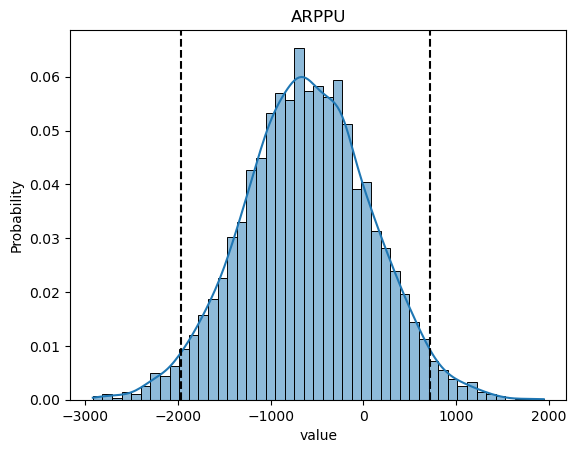

In [17]:
data = bootstrap_diffs_melt[bootstrap_diffs_melt["kpi"] == 'arppu_diff']
sns.histplot(data = data, x = 'value', kde = True, stat = 'probability', common_bins = True, fill = True).set(title='ARPPU')
plt.axvline(data['value'].quantile(lower_ci), color='k', linestyle='--')
plt.axvline(data['value'].quantile(upper_ci), color='k', linestyle='--')

# По методу бутстрап делаем вывод, что для метрики ARPPU нет стат. значимых отличий (0 лежит внутри 95% довер. интервала)

In [18]:
# Рассмотрим метрику среднего чека
# Расчет: для каждого пользователя отношение суммы выручки в период теста на количество чеков (в данном случае = транзакций)
# Проверим внутрипользовательские корреляции для подбора статистического критерия. 
# Для этого посмотрим максимальное и среднее количество покупок клиентов за период теста

purchases_by_group = orders.groupby(['group', 'id_user'])['id_trans'].count().reset_index()
print(purchases_by_group.groupby(['group'])['id_trans'].max())
print(purchases_by_group.groupby(['group'])['id_trans'].mean())

group
A    3
B    3
Name: id_trans, dtype: int64
group
A    1.051802
B    1.037951
Name: id_trans, dtype: float64


In [19]:
# В связи с тем, что один клиент обычно совершает более одной покупки, а покупки одного клиента зависимы между собой,
# то для проверки гипотезы о равенстве средних для метрики средний чека будем применять бустрап или дельта-метод

result_table = orders.groupby('group').agg({'id_trans': 'count','revenue': 'sum',}).reset_index()
result_table['Средний чек'] = result_table['revenue'] / result_table['id_trans']
result_table.columns = ['Группа', 'Количество транзакций', 'Сумма выручки', 'Средний чек']
result_table

# Средний чек в тестовой группы ниже, чем в контрольной

,Группа,Количество транзакций,Сумма выручки,Средний чек
0,A,467,3272106,7006.650964
1,B,547,3572562,6531.191956


In [20]:
a = orders[orders['group']=='A'].groupby('id_user')['revenue'].apply(list)
b = orders[orders['group']=='B'].groupby('id_user')['revenue'].apply(list)
check_delta_method(a,b)

# Вывод: значимого эффекта на средний чек с помощью баннера не было

0.459369523978441

In [21]:
# Рассмотрим метрику частоты покупок 
# Расчет: среднее количество транзакций на платящего клиента

result_table = orders.groupby('group').agg({'id_trans': 'count','id_user': 'nunique',}).reset_index()
result_table['Частота транзакций'] = result_table['id_trans'] / result_table['id_user']
result_table.columns = ['Группа', 'Количество транзакций', 'Количество клиентов', 'Частота транзакций']
result_table

# Среднее количество транзакций на платящего клиента в тестовой группе ниже, чем в контрольной

,Группа,Количество транзакций,Количество клиентов,Частота транзакций
0,A,467,444,1.051802
1,B,547,527,1.037951


In [22]:
a = list(purchases_by_group[purchases_by_group['group']=='A']['id_trans'])
b = list(purchases_by_group[purchases_by_group['group']=='B']['id_trans'])

mannwhitneyu(a,b).pvalue
# Вывод: С помощью критерия Манна-Уитни на 5% уровне значимости не можем отвергнуть гипотезу о наличии свигов в распределениях между группами по метрике частоты покупок

0.5872382979499797

[Text(0.5, 1.0, 'Частота покупок')]

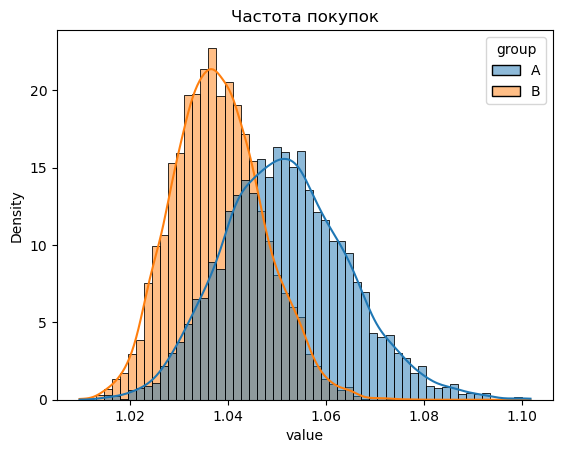

In [23]:
# Построим графики распределения средних для метрики количество транзакций на платящего клиента с помощью бутстрапа
sns.histplot(data = bootstrap_df_melt[bootstrap_df_melt['kpi'] == 'freq'], x = 'value', kde = True, stat = 'density', common_bins = True, fill = True, hue = 'group').set(title='Частота покупок')

# Распределение средних группы А немного сдвинуто вправо

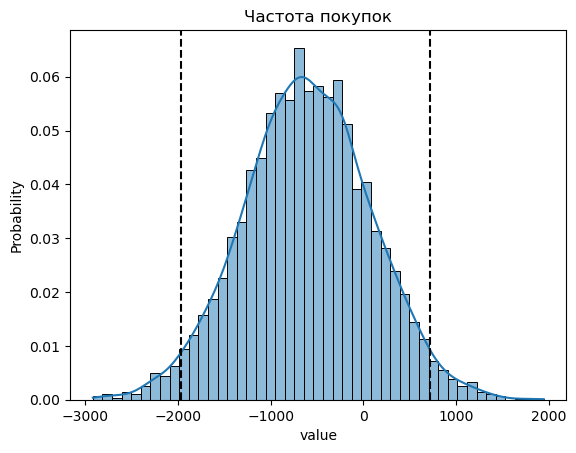

In [24]:
sns.histplot(data = data, x = 'value', kde = True, stat = 'probability', common_bins = True, fill = True).set(title='Частота покупок')
plt.axvline(data['value'].quantile(lower_ci), color='k', linestyle='--')
plt.axvline(data['value'].quantile(upper_ci), color='k', linestyle='--')
# По методу бутстрап делаем вывод, что для метрики частоты покупок нет стат. значимых отличий (0 лежит внутри 95% довер. интервала)

В качестве дополнительного исследования рассмотрим метрики выручки с дневной сессии и конверсии

In [25]:
# Рассмотрим метрику выручки с дневной сессии 
daily_session_rev = sessions_all.groupby(['group']).agg({'id_user': ['nunique','count'], 'revenue': ['sum','mean','std']}).reset_index()

daily_session_rev.columns = ['Группа', 'Количество пользователей', 'Количество сессий', 'Сумма выручки', 'Средняя выручка', 'Станд. откл. выручки']
daily_session_rev

# По метрике выручки с дневной сессии заметно, что средняя выручка с "дневной сессии" выросла (но метрика очень волатильна). 

,Группа,Количество пользователей,Количество сессий,Сумма выручки,Средняя выручка,Станд. откл. выручки
0,A,18724,18736,3272106,174.642720,2003.203234
1,B,18900,18916,3572562,188.864559,1941.976480


In [26]:
# Так как выручка с платящего пользователя имеет лог-нормальное распределение, то выручка с дневной сессии имеет то же распределение, 
# только в точке 0 добавится еще наблюдения от неплатящих пользователей

# Для проверки гипотезы о наличии свидга в распределениях будем использовать непараметрический критерий Манна-Уитни
a = list(sessions_all[sessions_all['group']=='A']['revenue'])
b = list(sessions_all[sessions_all['group']=='B']['revenue'])
mannwhitneyu(a, b).pvalue

# Вывод: С помощью критерия Манна-Уитни на 5% уровне значимости гипотеза о равенстве распределений отвергнута 
# -> видим статистически значимые различия в распределениях метрики 

0.008509548253396454

[Text(0.5, 1.0, 'Выручка с дневной сессии')]

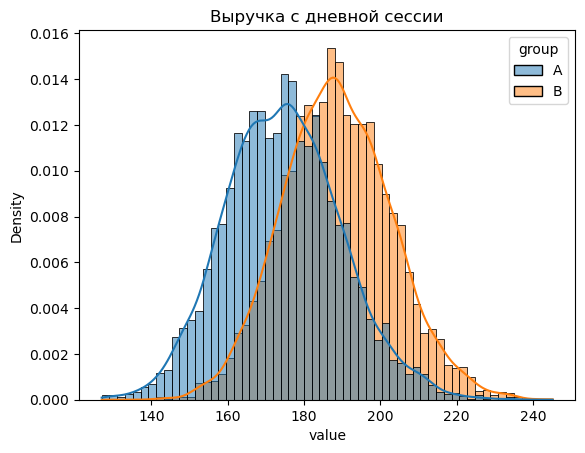

In [27]:
# Наличие стат. значимой разницы в средних проверим с помощью бутстрапа
sns.histplot(data = bootstrap_df_melt[bootstrap_df_melt['kpi'] == 'rev_per_session'], x = 'value', kde = True, stat = 'density', common_bins = True, fill = True, hue = 'group').set(title='Выручка с дневной сессии')

# Распределение средних группы В немного сдвинуто вправо

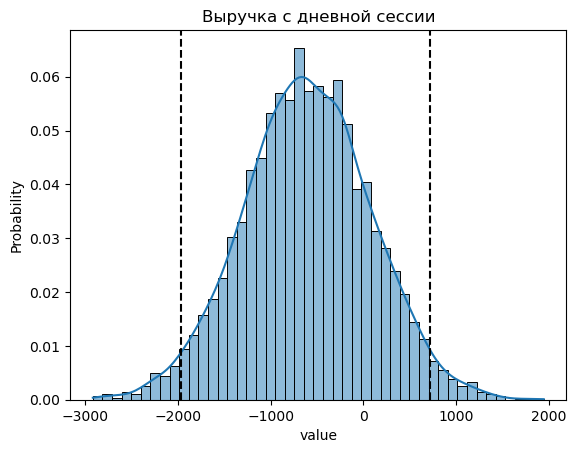

In [28]:
sns.histplot(data = data, x = 'value', kde = True, stat = 'probability', common_bins = True, fill = True).set(title='Выручка с дневной сессии')
plt.axvline(data['value'].quantile(lower_ci), color='k', linestyle='--')
plt.axvline(data['value'].quantile(upper_ci), color='k', linestyle='--')
# По методу бутстрап делаем вывод, что для средних значений метрики выручки с дневной сессии нет стат. значимых отличий по группам А и Б (0 лежит внутри 95% довер. интервала)

In [29]:
# Рассмотрим метрику конверсии из захода в покупку (в данном случае по дневным сессиям).
# Данная метрика имеет биномиальное распределение, в связи с чем для проверки гипотезы будем применять z-test
contingency_table = pd.crosstab(sessions_all['group'], sessions_all['conversion'])
contingency_table

conversion,0,1
group,,
A,18280,456
B,18373,543


In [30]:
a = list(sessions_all[sessions_all['group']=='A']['conversion'])
b = list(sessions_all[sessions_all['group']=='B']['conversion'])

ztest(a, b)[1]
# Для метрики конверсии в покупку наблюдаем стат. значимую разницу в средних по результатам z-теста на уровне 5% между вариантами с и без рекламного баннера

0.008367375342998456

## Выводы и рекомендации

При исследовании качества данных нашлись клиенты, которые видели вариант как контрольной, так и тестовой группы. Для получения более корректных результатов наблюдения по этим клиентам были удалены. Необходимо убедиться, что система сплитования работает корректно, и это попадание клиентов в обе группы слуйчайно. Кроме этого, наблюдений в части покупок относительно мало для желаемой мощности стат. тестов.

В ходе оценки результатов эксперимента были проверены основные метрики эксперимента: выручка с платящего клиента, средний чек, частота покупок (количество транзакций на клиента)
После анализа этих метрик, были рассмотрены метрики, которые по изначальной гипотезе не должны были различаться между группами  (конверсия из захода в покупку, выручка с дневной сессии).

По результатам проверки статистических гипотез сформированы следующие выводы:

1) Рекламный баннер не стимулировал платящих клиентов расширять свою корзину. По изначальному предположению, например, с помощью стимулирования вернуться с экрана оплаты и расширить текущий чек, либо после оплаты совершить дополнительную транзакцию. То есть как для каждой конкретной покупки (средний чек), так и для общего потребления клиентом за период теста стат. значимой разницы по эти метрикам между групп не наблюдается. Эти метрики для тестовой группы оказались ниже, чем для контрольной, но статистически значимых различий обнаружено не было.

2) После проверки дополнительных метрик оказалось, что есть стат. значимый эффект на конверсию из захода в покупку.

### Рекомендации:

Эксперимент показал, что показ рекламного баннера увеличивает конверсию в покупку. Предположительно, это наблюдение случайно (ошибка 1ого рода), так как введенное изменение было нацелено на тех клиентов, которые уже дошли до этапа оплаты. Таким образом, часть клиентов, которые не дошли до экрана оплаты не могли "почувствовать на себе влияние эксперимента", так как не видели баннер. А баннер, по предположению, был нацелен на действие после оплаты, а не на конверсию из захода в покупку.

Таким образом, для анализа случайности данного явления можно сделать следующее:

1) Проверить еще раз на какое целевое действие вел баннер на этапе оплаты.
2) Проверить возможное неслучайное влияние параллельных процессов / нерепрезентативность выборки.
3) Проверить конверсию в значимых для данного целевого действия разрезах, чтобы найти возможные аномалии.
4) Возможно, баннер "вел на" отложенное действие и можно посмотреть на поведение этих клиентов в долгом периоде (но нужно учесть, что их нужно будет "заморозить", что может оказаться неэффективным).

В качестве предложения: протестировать разные креативы, в том числе направленные на увеличение среднего чека. Например, провести тесты с креативами, ведущими на разные целевые действия, например, добавление в корзину дополнительного товара.